# Session 2:  MsPASS Generalized Headers (Metadata container)
## Discussion:  Headers
Discussion will be driven by a related set of powerpoint slides.


## Overview and learning objectives
In this session we aim to help you understand the following fundamental concepts in MsPASS:
- Generalized headers
- The MsPASS database handle
- MongoDB *collections* and *documents*.  *Collection*==*relation* and *document*==*tuple*
- A MongoDB document can be mapped into a python dictionary (*dict* container)
- In MongoDB "normalization" is comparable to a relational database join
- Performance in MongoDB requires an index unless the collection is small
- Default index is ObjectID, but others can be defined easily
- MsPASS uses a default schema that has options for enforcing modest to rigid rules on data types
- MsPASS has two data object:  *TimeSeries*=single channel data, *Seismogram*=three-component data
- Data arrays can be indexed in python as in C or Fortran, but more efficiently handled with compiled algorithms

## Database handles and miniseed input
This tutorial assumes you have already completed the session 1 getting started tutorial.  There we saved waveform data downloaded with FDSN web services to a folder called "./wf".  The timing data of that operation should convince you that web service input to a workflow is currently a bad idea.   In most cases, you will likely want to start processing with input from miniseed files.  In this session we are going to build an alternative form for handling input with raw miniseed data rather than loading data directly from web services.  

Reading directly from miniseed is a useful feature, but since most of the students in this course are likely to have some experience with miniseed the hope is the header namespace this creates will be familiar ground. We will also be using the paradigm of one file per channel of data that SAC users are familiar with.   We do that for the educational benefit.  We presume it is familiar ground to most students and helps clarify a key relationship of what metadata belong to which signal. A noteworth point, however, is we consider the model of one file per signal an abomination that needs to be exorcised from data management dogma because it creates horrible performance problems on HPC systems. We are using that model here only to aid your understanding.  Normal practice with miniseed files should be to put logically grouped data like event files.  

Our first step is to read the set of miniseed files we created in session1.  First, let's just use a python way to look into that directory:

In [1]:
import os
with os.scandir('./wf') as entries:
    for entry in entries:
        print(entry.name)

shortcourse_1107.mseed
shortcourse_1224.mseed
shortcourse_467.mseed
shortcourse_376.mseed
shortcourse_921.mseed
shortcourse_495.mseed
shortcourse_372.mseed
shortcourse_899.mseed
shortcourse_622.mseed
shortcourse_110.mseed
shortcourse_614.mseed
shortcourse_194.mseed
shortcourse_769.mseed
shortcourse_50.mseed
shortcourse_340.mseed
shortcourse_691.mseed
shortcourse_1132.mseed
shortcourse_982.mseed
shortcourse_224.mseed
shortcourse_452.mseed
shortcourse_1157.mseed
shortcourse_612.mseed
shortcourse_5.mseed
shortcourse_479.mseed
shortcourse_312.mseed
shortcourse_984.mseed
shortcourse_842.mseed
shortcourse_492.mseed
shortcourse_305.mseed
shortcourse_802.mseed
shortcourse_611.mseed
shortcourse_989.mseed
shortcourse_444.mseed
shortcourse_1218.mseed
shortcourse_1013.mseed
shortcourse_843.mseed
shortcourse_1081.mseed
shortcourse_172.mseed
shortcourse_170.mseed
shortcourse_95.mseed
shortcourse_1192.mseed
shortcourse_153.mseed
shortcourse_1063.mseed
shortcourse_667.mseed
shortcourse_424.mseed
short

The names are meaningless, but let's now build an index for this set of files and store them in our database.  To do that we first have to build the MsPASS handle used to access the data.  Variations of the following incantation will normally appear at the top of any MsPASS job script:

In [1]:
from mspasspy.db.client import DBClient
from mspasspy.db.database import Database
dbclient=DBClient()
dbh=Database(dbclient,'shortcourse')

There are two things created here that are important to understand:
1.  *dbclient* is an instance of a communication handle created to interact with MongoDB.  It is a minor variant of a pymongo class called *Client*.  (For those familiar with object oriented programming *DBClient* is a subclass/child of *Client*.).  It can be thought of as a top level handle for the entire database system.  It is normally created once and referenced only in calls like the last line of the box above.
2.  *dbh* is an instance of the MsPASS *Database* class.  *dbh* is a handle that we will use to manipulate a particular database, which in this case we called "shortcourse".  We will get more into the weeds of MongoDB later, but for now think of this as an abstract handle we use to interact with the database. 

With that our next step is to build an index to each of the files in "./wf".   

In [3]:
with os.scandir('./wf') as entries:
    for entry in entries:
        if entry.is_file():
            filename='./wf'+'/'+entry.name
            dbh.index_mseed_file(filename)

In [4]:
n=dbh.wf_miniseed.count_documents({})
print('Number of documents in wf_miniseed collection=',n)

Number of documents in wf_miniseed collection= 1287


## MongoDB documents and collections
If you run a shell and run ls on the wf directory you will find that we started with 1287 miniseed files.  Hence, for this example we created one "document" in our database for each file.   We'll dig into the syntax for *count_documents* and the related *find* function of pymongo in a moment, but for now let's have a look at what these "documents" contain.  To do this we are going to make a prettier print than the default using a nice json utility provided through MongoDB called json_util:

In [3]:
from bson import json_util
cursor=dbh.wf_miniseed.find({}).limit(3)  # this means select the first 3 documents
for doc in cursor:
    print(json_util.dumps(doc,indent=5))


{
     "_id": {
          "$oid": "60e8603f4f71d3075de04f03"
     },
     "sta": "TPFO",
     "net": "TA",
     "chan": "BHE",
     "sampling_rate": 40.0,
     "delta": 0.025,
     "starttime": 1302187287.1249979,
     "last_packet_time": 1302188736.399998,
     "foff": 0,
     "nbytes": 49152,
     "storage_mode": "file",
     "format": "mseed",
     "dir": "/home/pavlis/tutorials/mspass_tutorial/sage-gage_2021",
     "dfile": "./wf/shortcourse_1107.mseed"
}
{
     "_id": {
          "$oid": "60e8603f4f71d3075de04f04"
     },
     "sta": "X39A",
     "net": "TA",
     "chan": "BHE",
     "sampling_rate": 40.0,
     "delta": 0.025,
     "starttime": 1302187287.1,
     "last_packet_time": 1302188716.5249999,
     "foff": 0,
     "nbytes": 45056,
     "storage_mode": "file",
     "format": "mseed",
     "dir": "/home/pavlis/tutorials/mspass_tutorial/sage-gage_2021",
     "dfile": "./wf/shortcourse_1224.mseed"
}
{
     "_id": {
          "$oid": "60e8603f4f71d3075de04f05"
     },
     "st

Some key points to learn from this output:
- A MongoDB document is made up only of a set of name-value pairs
- The names (keys) are like header name fields, but less restictive
- The "values" in the name-value pairs can be almost anything (examples here are int, float, and string plus an obscure thing we will visit momentarily with the key "_id")
- Those familiar with miniseed can likely guess what most of these attributes are.  *Discuss*
- A "document" looks and acts like (it isn't actually, but that is an advanced topic) a python dictionary (dict)
- A "collection" in MongoDB is a set of "documents" that are grouped under a particular name.  In our example so far we have used the name "wf_miniseed".  

Because MongoDB documents are a container that acts like a python dictionary it is pretty easy to write a simple report generator showing only data associated with a particular key in tabular form.  Here is a simple example that prints only some data for the first 5 documents.

In [4]:
from obspy import UTCDateTime
print('counter net sta chan starttime samplerate nbytes')
cursor=dbh.wf_miniseed.find({}).limit(3)
i=0
for doc in cursor:
    net=doc['net']
    sta=doc['sta']
    chan=doc['chan']
    stime=doc['starttime']
    samprate=doc['sampling_rate']
    nb=doc['nbytes']
    print(i,net,sta,chan,UTCDateTime(stime),samprate,nb)
    i+=1

counter net sta chan starttime samplerate nbytes
0 TA TPFO BHE 2011-04-07T14:41:27.124998Z 40.0 49152
1 TA X39A BHE 2011-04-07T14:41:27.100000Z 40.0 45056
2 TA E26A BHZ 2011-04-07T14:41:27.100000Z 40.0 61440


The point of that short script was that you can access a member of a document with the key using python dict syntax.   

## MsPASS abstraction of data reading
An important design goal of MsPASS was making basic reads and writes of data objects with a database handle (*dbh* we created above and use in the boxes above) simple.   Readers are driven by "documents" as we can see in this example that produces an output comparable to the example above:  

In [5]:
cursor=dbh.wf_miniseed.find({}).limit(3)
i=0
for doc in cursor:
    d=dbh.read_data(doc,collection='wf_miniseed')
    print('Metadata for data object number ',i)
    print(d)
    i+=1

Metadata for data object number  0
{'_id': ObjectId('60e8603f4f71d3075de04f03'), 'chan': 'BHE', 'delta': 0.025000, 'dfile': './wf/shortcourse_1107.mseed', 'dir': '/home/pavlis/tutorials/mspass_tutorial/sage-gage_2021', 'foff': 0, 'format': 'mseed', 'last_packet_time': 1302188736.399998, 'nbytes': 49152, 'net': 'TA', 'npts': 57971, 'sampling_rate': 40.000000, 'sta': 'TPFO', 'starttime': 1302187287.124998, 'storage_mode': 'file'}
Metadata for data object number  1
{'_id': ObjectId('60e8603f4f71d3075de04f04'), 'chan': 'BHE', 'delta': 0.025000, 'dfile': './wf/shortcourse_1224.mseed', 'dir': '/home/pavlis/tutorials/mspass_tutorial/sage-gage_2021', 'foff': 0, 'format': 'mseed', 'last_packet_time': 1302188716.525000, 'nbytes': 45056, 'net': 'TA', 'npts': 57177, 'sampling_rate': 40.000000, 'sta': 'X39A', 'starttime': 1302187287.100000, 'storage_mode': 'file'}
Metadata for data object number  2
{'_id': ObjectId('60e8603f4f71d3075de04f05'), 'chan': 'BHZ', 'delta': 0.025000, 'dfile': './wf/shortc

Our print line calls the output *Metadata*.  That is the name we give it, but you should think of it as a generalized header.  Print just shows the metadata, but you should realize that the symbol *d* now contains a single channel of seismic data (the last one listed in this case; the Z channel of TA station E26A).  To show that let's plot it:

First this is what python says is the type of d:   <class 'mspasspy.ccore.seismic.TimeSeries'>


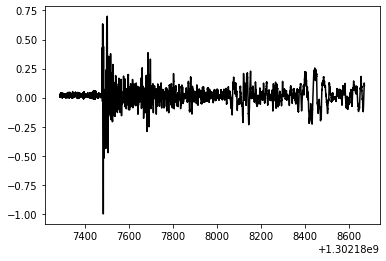

In [6]:
print('First this is what python says is the type of d:  ',type(d))
from mspasspy.graphics import SeismicPlotter
plotter=SeismicPlotter(normalize=True)
plotter.change_style('wt')
plotter.plot(d)

There are currently four data objects supported natively in MsPASS:
1.  A *TimeSeries* is a single channel of data like the example we just plotted.
2.  A *Seismogram* is an abstraction of three-component data that has native methods for handling some common operations on such data (e.g. rotation of coordinates to radial, tranverse, and vertical).  
3.  A *TimeSeriesEnsemble* is a bundle of *TimeSeries* objects.   In reflection processing it would be called a "gather".
4.  A *SeismogramEnsemble* is a bundle of *Seismogram* objects.   It has a completely parallel data structure to a *TimeSeriesEnsemble*, but the member attribute contains *Seismogram* objects intead of *TimeSeries* objects. 

For more details about the concepts behind these data objects see appropriate sections of the User's Manual found at https://www.mspass.org/.

There are database readers and writers that make loading from and saving to the database as simple as possible.  We saw a reader that creates *TimeSeries* data from miniseed files, but here is another example that reads and plots a single *Seismogram* object from the dataset you created and loaded in session 1:  

This is what python says is the type of d:  <class 'mspasspy.ccore.seismic.Seismogram'>


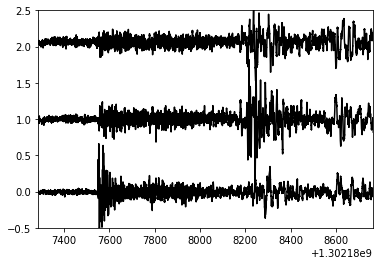

In [8]:
doc=dbh.wf_Seismogram.find_one()
d=dbh.read_data(doc,collection='wf_Seismogram')
print('This is what python says is the type of d: ',type(d))
plotter.plot(d)

Saving this data after doing something is equally easy.  In the next block we will apply a short-period filter to the above data, plot it, and then save it back to our database.

save_data returned this:  [ObjectId('60ef160b4b38a3c666284a48'), None, ObjectId('60ef160b4b38a3c666284a49')]


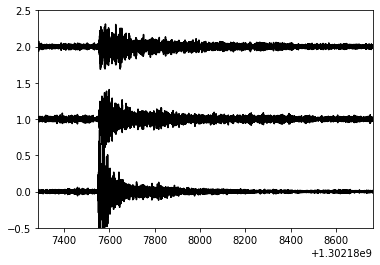

In [9]:
from mspasspy.algorithms.signals import filter
filter(d,type='bandpass',freqmax=2.0,freqmin=0.8)
plotter.plot(d)
ret=dbh.save_data(d,data_tag='spfiltered_example')
print('save_data returned this: ',ret)

In [13]:
print(d)
x=d.elog.get_error_log()
print(x)

{'_id': ObjectId('60ef160b4b38a3c666284a48'), 'calib': 1.000000, 'cardinal': False, 'chan': 'E', 'delta': 0.025000, 'elog_id': ObjectId('60e85e40c07df331e011ed46'), 'endtime': 1302188764.100000, 'gridfs_id': ObjectId('60e85e40c07df331e011ed48'), 'history_object_id': '3bf03f38-c449-48eb-90b8-eb6fabc7a3bd', 'loc': '', 'net': '', 'npts': 59081, 'orthogonal': False, 'processing': ["ObsPy 1.2.2: filter(options={'freqmax': 2.0, 'freqmin': 0.8}::type='bandpass')"], 'sampling_rate': 40.000000, 'site_id': ObjectId('60e83a48c07df331e011d91b'), 'source_id': ObjectId('60e83a40c07df331e011d40a'), 'sta': '', 'starttime': 1302187287.100000, 'storage_mode': 'gridfs', 'time_standard': 'UTC', 'tmatrix': [-2.6484540326036093e-14, -1.0, 2.6484540326036093e-14, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0], 'utc_convertible': True}
[LogData({'job_id': 0, 'p_id': 477990, 'algorithm': 'Database.save_data', 'message': 'readonly attribute with key=sta was improperly modified.  Saved changed value with key=READONLYERROR_sta', 

That is about as simple as it could be.  The only option we used in this case was the *data_tag* option.   A *data_tag* is used as a simple mechanism to identify a save done at a particular stage of processing.   To see that consider the following small script that counts the number of data stored without such a tag and the number stored with the one we just used:

In [11]:
ntotal=dbh.wf_Seismogram.count_documents({})
print('Total number of Seismogram objects currently stored=',ntotal)
query={'data_tag' : 'spfiltered_example'}
nsp=dbh.wf_Seismogram.count_documents({'data_tag' : 'spfiltered_example'}) 
nnull=dbh.wf_Seismogram.count_documents({'data_tag' : {'$exists' : False}})
print('Number of data with tag spfiltered tag=',nsp)
print('Number of data with no tag or another tag=',nnull)

Total number of Seismogram objects currently stored= 428
Number of data with tag spfiltered tag= 0
Number of data with no tag or another tag= 428


The same Database method can be used for saving and reading *TimeSeries* objects as illustrated elsewhere in notebooks used in this tutorial    There are also readers and writers for ensembles that have the names *read_ensemble_data* and *save_ensemble_data* respectively.  They are described in MsPASS User's manual python API.  Because of time limits we leave it as an exercise for the student to apply them.  

In the above we used some incantations passed to MongoDB.   Before explaining that magic we need to discuss some basic concepts of MongoDB and how it is used in MsPASS.

## MongoDB Concepts
First a caveat.  MongoDB is itself a complex piece of modern software.   As a common open-source package there are numerous online tutorials and several books to teach you how to use the software.  MongoDB is NOT a relational database, but one of a range of what are sometimes called "noSQL database" systems.   Other noSQL databases have been experimented with in the geosciences in recent years, but to our knowledge MsPASS is the first application of the type of database that is implemented in MongoDB.  MongoDB is an implementation of a class of databases called a "document database".  Students familiar with relational databases may find MongoDB confusing while we suspect those without that training will find it actually easier to use than any relational system with which we are familiar.  We cannot cover all the things you will need to know about MongoDB to use MsPASS effectively, but stress the documentation is so extensive you should have not problem teaching yourself everything you need to know about it.  Fundamental concepts we need you, however, to understand today to be able to use MsPASS effectively are the following:
* Above we gave an introduction to the idea of a *collection* and *document*.   We need to expand that basic understanding, especially defining what "collections" are defined by default in MsPASS.  In particular, MsPASS uses a set of "normalization" collections for storage efficiency.  
* A relational database depends heavily upon a schema to be at all functional.  MongoDB can be run without any schema restriction, but doing so is a bit if an invitation to disaster.   The MsPASS Database handle has an implict set of loose schema restrictions we will introduce here.  We note the schema can be altered by the user, but that topic will not be covered in this course for lack of time.
* We saw a few examples of queries above. We will cover some basics to help you get started.
* MongoDB makes extensive use of indices and depends upon them for efficiency.
* Data storage concepts we use in MsPASS are a mix of pure MongoDB stores and file system stores.  Understanding where your data live is fundamental for a long list of reasons.

Each of these topics are covered in subsections below.  They were designed to be explored in any order you choose, but the usual top down progress is the safest.


### Documents, collections, and schema basics
Above you should have learned that a *document* is made up of a set of name-value pairs and a *collection* is a set (collection) of documents.  For those familiar with relational databases we reiterate that a *document* is equivalent to a single tuple in a relation (table) and a *collection* is roughly equivalent to a single relation (table).  For the novice, we mote that a *schema* in a relational database defines all the table/relation and attribute names and how the tables/relations are expected to be linked together (join keys). MongoDB actually has no such rules at all.  It only understands that a document is a bunch of name-value pairs and the only real restriction is a key in a document can be used only once in that document. For a system like MsPASS there has to be some agreement on what concept the attribute a particular key reference is. (e.g. 'time' is a completely ambiguous name by itself and could be used to mean a long list of concept in seismology with a qualification.)  The Database handle in MsPASS is aware of the following collection names by default:
1.  There are a series of collections that are used to define waveform data.   All names of all of these begin with the string "wf_".  Currently there are three standard names:  (a) *wf_miniseed* (used above) is used to hold an index of raw data stored in the miniseed format; (b) *wf_TimeSeries* is used to data stored as single-channel records; and (c) *wf_Seismogram* is used to stored data prebundled into three components (see example above).  Note the naming convention has natural extension to other raw formats.  e.g. it would be easy to build a reader for segy on sac data that with this convention would be called *wf_segy* and *wf_sac* respectively.   The system was designed so reading other formats like that could be done through the same database reader as wf_miniseed like the example above (e.g. dbh.read_data(collection='wf_sac').  That illustrates a fundamental concept not fully appreciated by most seismologists:  the data is not the format.   We use the wf collections to separate the format from the generic concept we aimed to capture in our TimeSeries and Seismogram objects.
2. Most raw data requires some basic information about what sensor recorded the data.   In MsPASS these are defined by two collections:  (a) *channel* is used to define receiver properties of *TimeSeries* objects and (b) *site* is used to define receiver properties of *Seismogram* objects.   Note response data is stored on in *channel* collections because response information always refers to a single channel of data.  *site*, in contrast, is largely a place to store geographic location information.
3. Any study using event data needs to associate source information with each datum.  We use the *source* collection to save that metadata. 
4. There are internal collections used by MongoDB and defined under the hood by MsPASS.  Three are defined by MsPASS:  *elog*, *history_global*, and *history_object*.  They are used to store error logs and processing history and will not be covered in detail in this course due to lack of time.  For MongoDB specific collections for now we direct you to the MongoDB documentation.  

In session 1 you actually added documents to most of these collections.  Each of the boxes below show you the basic content (we omit wf_miniseed as we looked at it earlier).  Execute each of these and we will have brief discussion of the content:

In [35]:
collection_list=['wf_TimeSeries','wf_Seismogram','channel','site','source','elog']
for col in collection_list:
    print('First document in collection=',col)
    dbcol=dbh[col]
    doc=dbcol.find_one()
    print(json_util.dumps(doc,indent=5))

First document in collection= wf_TimeSeries
{
     "_id": {
          "$oid": "60e841f9c07df331e011d921"
     },
     "_fdsnws_dataselect_url": "http://service.iris.edu/fdsnws/dataselect/1/query",
     "_format": "MSEED",
     "calib": 1.0,
     "chan": "BHE",
     "delta": 0.025,
     "endtime": 1302188764.1,
     "mseed": {
          "dataquality": "M",
          "number_of_records": 15,
          "encoding": "STEIM2",
          "byteorder": ">",
          "record_length": 4096,
          "filesize": 100441600
     },
     "net": "TA",
     "npts": 59081,
     "processing": [
          "ObsPy 1.2.2: trim(endtime=UTCDateTime(2011, 4, 7, 15, 6, 4, 100000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2011, 4, 7, 14, 41, 27, 100000))"
     ],
     "sampling_rate": 40.0,
     "source_id": {
          "$oid": "60e83a40c07df331e011d40a"
     },
     "sta": "034A",
     "starttime": 1302187287.1,
     "time_standard": "UTC",
     "utc_convertible": true,
     "grid

### Normalization
Any students who have used Antelope or other software based on the standard CSS3.0 relational database schema might notice *site* and *channel* contain information similar to the *site* and *sitechan* (respectively) tables defined by CSS3.0.   We define these collections for the same reason they were defined decades ago in CSS3.0:  for most seismic data there is a one to many relationship between site and the waveform data (i.e. each instrument records many waveforms).   For that reason it is extremely inefficient (for database store that is) to store a copy of station metadata with each waveform in a header structure like SAC or SEGY.  In a relational database a "join" operator is normally used to associate the receiver metadata with each waveform.   MongoDB calls this same basic concept *normalization*.  They use a different name because what is done under the hood is quite different, but conceptually *normalize* and *join* do the same thing.  That is, if we *normalize* the receiver data retreived in a read we will automatically load the receiver metadata.

Source information has similarities and difference with receiver metadata.  We store such data in the *source* collection. Typical content is illustrated above. Some data has a natural link to source information.  A type example is a collection of waveforms from an recent earthquake assembled for a moment tensor inversion.  Other data sets like noise-correlation studies don't care about source information at all except for editing. For that reason a reader should be dogmatic about demanding source data be defined. In fact, all "normalization data" in MsPASS is only loaded if requested.   

To see how that works, let's compare reading the same data with and without normalization with the following example.  Here were normalize Seismogram data with *site* and *source* data we loaded in session1.

In [2]:
doc=dbh.wf_Seismogram.find_one()
d_plain=dbh.read_data(doc,collection='wf_Seismogram')
normalize_list=['site','source']
d_normalized=dbh.read_data(doc,collection='wf_Seismogram',normalize=normalize_list)
# In this loop we compare data loaded with each copy with the MsPASS Metadata container API
# Metadata is also like a python dict, but has a few additional features exploited here
print('key  d_normalized  d_plain')
normalize_keys=list()  # We use this in the next box
for k in d_normalized.keys():
    if d_plain.is_defined(k):
        plain_value=d_plain[k]
    else:
        plain_value='UNDEFINED'
        normalize_keys.append(k)
    print(k,d_normalized[k],plain_value)

    

key  d_normalized  d_plain
cardinal False False
data_tag schema_feature_demonstration schema_feature_demonstration
source_lon 141.7296 UNDEFINED
READONLYERROR_sta Z41A Z41A
source_depth 53.2 UNDEFINED
READONLYERROR_site_lon -92.803001 -92.803001
time_standard UTC UTC
READONLYERROR_source_lat 38.2525 38.2525
READONLYERROR_site_lat 33.257702 33.257702
chan E E
loc  UNDEFINED
READONLYERROR_site_starttime 1299715200.0 1299715200.0
endtime 1302188764.100001 1302188764.100001
READONLYERROR_site_elev 0.062 0.062
source_lat 38.2513 UNDEFINED
processing ["ObsPy 1.2.2: filter(options={'freqmax': 2.0, 'freqmin': 0.8}::type='bandpass')", "ObsPy 1.2.2: filter(options={'freqmax': 2.0, 'freqmin': 0.8}::type='bandpass')", "ObsPy 1.2.2: filter(options={'freqmax': 2.0, 'freqmin': 0.8}::type='bandpass')", "ObsPy 1.2.2: filter(options={'freqmax': 2.0, 'freqmin': 0.8}::type='bandpass')"] ["ObsPy 1.2.2: filter(options={'freqmax': 2.0, 'freqmin': 0.8}::type='bandpass')", "ObsPy 1.2.2: filter(options={'freqma

Let's do a little trick to separate the wheat from the chaff here using the normalize_keys list we saved in the script above:

In [40]:
print('Metadata key-value pairs added by normalization')
normalize_keys.sort()
for k in normalize_keys:
    print(k,d_normalized[k])

Metadata key-value pairs added by normalization
loc 
net TA
site_elev 0.062
site_endtime 1470873599.0
site_lat 33.257702
site_lon -92.803001
site_starttime 1299715200.0
source_depth 53.2
source_lat 38.2513
source_lon 141.7296
source_magnitude 7.1
source_time 1302186764.1
sta Z41A


Discussion:
* What is the magic that happened here?  
* Do you see our naming convention on normalized attributes?

### ObjectIDs and Indices
In a relational database tables are "joined" using common keys.   One of the simplest keys used a lot in many relational database schemas, including CSS3.0 in particular, are integers.   The reason is there are very fast algorithms for indexing integers, but they can have the dark side of being difficult to maintain because all computing integers are defined by a finite set of bits.  A collection in MongoDB, by default, has only one unique index referenced with the special key *_id*.  The value assigned to the *_id* key is a bound to a python class called an ObjectID seen by this set of incantations done on the doc used immediately above. 

In [41]:
print(doc['_id'],type(doc['_id']))

60e85e40c07df331e011ed3e <class 'bson.objectid.ObjectId'>


The point this shows is that an ObjectID is defined by a byte string that is uniquely assigned by the server.  It is data that is never intended to be manipulated directly by a human, but only as a programming construct.  We emphasize that every collection document always has a unique ObjectID associated with the key *_id* and that key is always automatically indexed.   We used that feature above in our normalization.  Here is what we used under the hood:

In [42]:
print('site_id=',doc['site_id'])
print('source_id=',doc['source_id'])

site_id= 60e83a48c07df331e011d91e
source_id= 60e83a40c07df331e011d40a


Both are cross-referencing ids we created in the scripts we ran in session 1.  

Before leaving this topic, we emphasize that other collection indices are possible and often highly advised.  For example the following builds a SEED centric index on the site collection:

In [44]:
dbh.site.create_index(
  [
    ('net',1),
    ('sta',1)
  ]
)

'net_1_sta_1'

Noting the syntax of this is a more than a little weird, but it says build an index with net sorted in ascending order (1) followed by sta also in ascending order.  See online sources and books on MongoDB for more about indices.

## Schema
Wikepedia defines a database schema as follows:  "refers to the organization of data as a blueprint of how the database is constructed (divided into database tables in the case of relational databases)."  The standard library for python interaction with MongoDB, which is called pymongo, has no schema implementation.  To be functional as a system, however, some rules are required or the odds of any job running approach zero.   The constructor for the *Database* class in MsPASS loads a default schema definition with the (perhaps) obvious name mspass.  The schema is defined by a text file in a format called "yaml" (yet another markup language).  It is relatively easy to extend the default schema file, but we will not cover that topic in this course for lack of time.  We refer the student to the User's Manual (https://www.mspass.org/
) section on this topic when the need arises.  For today we will focus on what rules the schema imposes on you and tools for cleaning up inconsistencies.

By default an instance of the database handle (*Database*) operates in mode we call *promiscuous*.  In that mode, the Metadata of a data object can contain (almost) anything as a value linked to a key and it will be saved when you call the *save_data* or *save_ensemble_data* method of Database.  In that mode if you add data with a keyword not known in the schema that data will be silently saved with that key and no error will be logged.  (Other modes described in the User's Manual would be more rigid in enforcing an undefined name rule.)  The main problem you can encounter is mismatches with normalized data or any attribute the schema defines as "readonly".   The readonly feature is enforceable because the Metadata container we use keeps track of any attribute that is modified after initial loading of attributes (construction).   It is always considered an error to alter data attached to a readonly attribute.   To see what we mean, let's intentionally do something evil to the Seismogram we loaded above with the symbol d_normalized, save it, and look at what happens:

In [3]:
# We will manually change the source coordinates which the schema defines as readonly
# Might be done innocently to add a revised location estimate from a different source
d_normalized['source_lat']=38.2525
d_normalized['source_lon']=141.73
dbh.save_data(d_normalized,collection='wf_Seismogram',data_tag='schema_feature_demonstration2')
doc=dbh.wf_Seismogram.find_one({'data_tag' : 'schema_feature_demonstration2'})
print(json_util.dumps(doc,indent=5))

NameError: name 'json_util' is not defined

In [5]:
from bson import json_util
n=dbh.wf_Seismogram.count_documents({'data_tag' : 'schema_feature_demonstration2'})
print(n)
print(json_util.dumps(doc,indent=3))

1
{
   "_id": {
      "$oid": "60e85e40c07df331e011ed3e"
   },
   "calib": 1.0,
   "delta": 0.025,
   "gridfs_id": {
      "$oid": "60eb37be7fec212d18550c7d"
   },
   "npts": 59081,
   "sampling_rate": 40.0,
   "site_id": {
      "$oid": "60e83a48c07df331e011d91e"
   },
   "source_id": {
      "$oid": "60e83a40c07df331e011d40a"
   },
   "starttime": 1302187287.100001,
   "storage_mode": "gridfs",
   "time_standard": "UTC",
   "tmatrix": [
      -2.6484540326036093e-14,
      -1.0,
      2.6484540326036093e-14,
      0.0,
      0.0,
      1.0,
      0.0,
      0.0,
      1.0
   ],
   "utc_convertible": true,
   "history_object_id": "f981a9d3-eda1-42e7-827a-69fbeebfc22a",
   "elog_id": {
      "$oid": "60eb37be7fec212d18550c7c"
   },
   "cardinal": false,
   "chan": "E",
   "data_tag": "schema_feature_demonstration2",
   "endtime": 1302188764.100001,
   "orthogonal": false,
   "processing": [
      "ObsPy 1.2.2: filter(options={'freqmax': 2.0, 'freqmin': 0.8}::type='bandpass')",
      "O

## Python API for manipulating sample data

## Homework exercises
1. Read and plot a single waveform from the wf_TimeSeries collection.
2. Read and plot a subset of waveforms from wf_Timeseries using read_ensemble_data and MongoDB cursor produced by a query.  For some queries (e.g. Z channels) you might want to use the limit method to make the plot readable in this notebook. 
3.  Read the entire raw data from the wf_Seismogram collection as a SeismogramEnsemble using *read_ensemble_data*, filter it as you choose, and save the results (with a unique *data_tag*) with *save_ensemble_data*.
4.  Build an index for the wf_TimeSeries collection using net:sta:chan.  